In [ ]:
import pandas as pd
import numpy as np
import re
import os
from datetime import datetime

import matplotlib.pyplot as plt

from keras.models import Sequential,Model
from keras.layers import Dense
import keras.optimizers as optimizers
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l2

In [ ]:
X = np.load("suspended_robot_X_data.npy",allow_pickle=True)
Y = np.load("suspended_robot_Y_data.npy",allow_pickle=True)

In [34]:
X.shape, Y.shape

((442368, 10), (442368, 1))

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,train_size=0.7,test_size=0.3,random_state=100,shuffle=True)

In [37]:
X_train.shape,Y_train.shape,X_test.shape,Y_test.shape

((309657, 10), (309657, 1), (132711, 10), (132711, 1))

In [69]:
model = Sequential()
model.add(Dense(100,input_dim = X_train.shape[1],activation="relu"))
model.add(Dense(50,activation="relu"))
model.add(Dense(5,activation="relu"))
model.add(Dense(Y_train.shape[1],activation="linear"))

optimizer = optimizers.adam(lr=0.01)
model.compile(optimizer = optimizer,loss="mean_squared_error",metrics=["mse","mae"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 100)               1100      
_________________________________________________________________
dense_10 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 255       
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 6         
Total params: 6,411
Trainable params: 6,411
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from datetime import datetime
curr_date_time = datetime.now()
model_name = "SuspendedBot_" + "_" + str(curr_date_time).replace(' ','').replace(':','_') + '/'
if not os.path.exists(model_name):
    os.mkdir(model_name)
    
filepath = model_name + '_' + 'model-' + '{epoch:05d}-{loss:.5f}-{val_loss:.5f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
callbacks_list = [checkpoint]

In [72]:
epoch_len = 10
model_history = model.fit(x=X_train,
          y=Y_train,
          epochs = epoch_len,
          verbose = 1,
          validation_data = (X_test,Y_test),
          batch_size = 100,
          callbacks = callbacks_list)

Train on 309657 samples, validate on 132711 samples
Epoch 1/10
309657/309657 [==============================] - 6s 18us/step - loss: 0.0269 - mean_squared_error: 0.0269 - mean_absolute_error: 0.0755 - val_loss: 0.0022 - val_mean_squared_error: 0.0022 - val_mean_absolute_error: 0.0344

Epoch 00001: val_loss improved from inf to 0.00222, saving model to SuspendedBot__2019-08-2606_45_43.820505/_model-00001-0.02686-0.00222.h5
Epoch 2/10
309657/309657 [==============================] - 5s 17us/step - loss: 0.0023 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0359 - val_loss: 0.0023 - val_mean_squared_error: 0.0023 - val_mean_absolute_error: 0.0401

Epoch 00002: val_loss did not improve from 0.00222
Epoch 3/10
309657/309657 [==============================] - 5s 17us/step - loss: 0.0017 - mean_squared_error: 0.0017 - mean_absolute_error: 0.0318 - val_loss: 0.0018 - val_mean_squared_error: 0.0018 - val_mean_absolute_error: 0.0362

Epoch 00003: val_loss improved from 0.00222 to 0.00183,

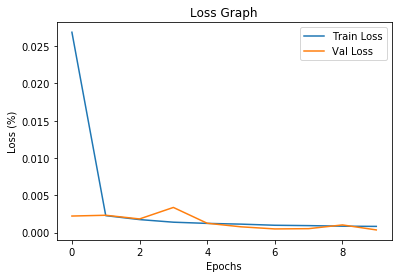

In [74]:
plt.plot(range(0,epoch_len,1),model_history.history["loss"])
plt.plot(range(0,epoch_len,1),model_history.history["val_loss"])
plt.legend(["Train Loss","Val Loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss (%)")
plt.title("Loss Graph")
plt.show()

In [83]:
print("Minimum Validation Loss = %f achieved at epoch iteration = %d" %(np.array(model_history.history["val_loss"]).min(),np.array(model_history.history["val_loss"]).argmin() + 1))
sel_model_idx = np.array(model_history.history["val_loss"]).argmin() + 1

Minimum Validation Loss = 0.000362 achieved at epoch iteration = 10


In [85]:
search_string = "model-0*" + str(sel_model_idx) + "-[a-z0-9\-\.]*"
selected_model_name = model_name + list(filter(lambda x: re.search(search_string,x),os.listdir(model_name)))[0]
print("Selected model name : %s" %(selected_model_name))

Selected model name : SuspendedBot__2019-08-2606_45_43.820505/_model-00010-0.00083-0.00036.h5


In [ ]:
from keras.models import clone_model
selected_model = clone_model(model)
selected_model.load_weights(selected_model_name)

In [ ]:
Y_test_pred = selected_model.predict(X_test)

In [ ]:
error = Y_test - Y_test_pred

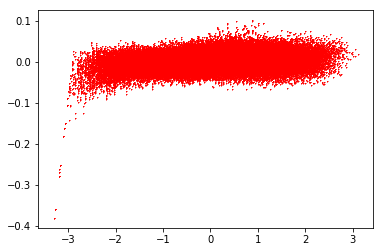

In [89]:
import matplotlib.pyplot as plt
plt.plot(Y_test,error,"r+",markersize=1)
plt.show()

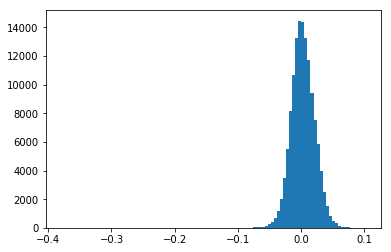

In [90]:
plt.hist(error,bins=100)
plt.show()

In [ ]:
import pickle
with open("Y_theta_value_scalar.pkl","rb") as f:
    scalar_obj = pickle.load(f)

In [ ]:
Y_test_unscaled = scalar_obj.inverse_transform(Y_test)
Y_test_pred_unscaled = scalar_obj.inverse_transform(Y_test_pred)
error_unscaled = Y_test_unscaled - Y_test_pred_unscaled

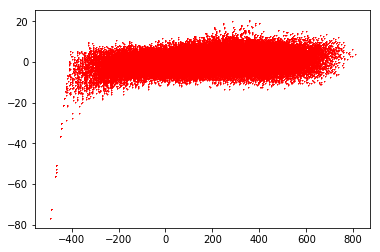

In [93]:
plt.plot(Y_test_unscaled,error_unscaled,"r+",markersize=1)
plt.show()

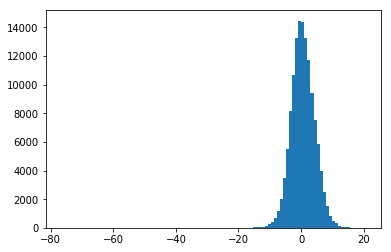

In [94]:
plt.hist(error_unscaled,bins=100)
plt.show()